# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [2]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 809kB/s 
     |████████████████████████████████| 2.2MB 8.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20200912-cp36-none-any.whl size=43996 sha256=26beff5480a81291e9b87311c26c31b685773599649e4c6790999638f16847a8
  Stored in directory: /root/.cache/pip/wheels/34/41/7b/f0a0b5800bea0474ae553342bde52093fdd5852764463aa2ec
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [2]:
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import os
import json
import random
from shutil import copyfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
from IPython.display import clear_output

# New Section

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:17, 10.0MB/s]                           


In [5]:
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
    A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
    label: A 2D array with integer type, storing the segmentation label.

    Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

    Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


LABEL_NAMES = np.asarray([
    'background', 'couch', 'chair', 'bed', 'vase', 'bowl', 'cup',
    'wine-glass', 'potted-plant'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

coco_class_to_label_mapping = {"couch":57, "chair":56, "bed":59, "vase":75, "bowl":45, 
                               "cup":41, "wine-glass":40, "potted-plant":58}

In [55]:
"""
base_url1 = "/content/drive/My Drive/aim/vision-project/"
base_url2 = "/content/drive/My Drive/aim/vision-project/classwise_product_imgs/"
base_url3 = "/content/drive/My Drive/aim/vision-project/segmentation_dataset/"

for label_id, cl in enumerate(LABEL_NAMES[1:]):
  #for fp in os.listdir("sample_data/classwise_product_imgs/"+cl+"/"):
  print(cl)
  for fp in os.listdir(base_url2+cl+"/"):
    if not fp.startswith("."):
      im = cv2.imread(base_url2+cl+"/" + fp)
      outputs = predictor(im)

      coco_id = coco_class_to_label_mapping[cl];
      cls = outputs["instances"][outputs["instances"].pred_classes == coco_id].to("cpu")
      if len(cls) > 0:
        cls = cls[0]

        if cls.scores[0] > 0.75:
          # Save image
          src = base_url2+cl+"/"+fp
          dest = base_url3+"confidence>0.75/JPEGImages/"+fp
          copyfile(src, dest);

          seg_map = np.zeros(cls.pred_masks.size())
          seg_map[cls.pred_masks == True] = label_id+1
          seg_map = seg_map[0]
          seg_map = seg_map.astype(np.uint8)

          ## Save mask as image
          #seg_image = label_to_color_image(seg_map).astype(np.uint8)
          #im = Image.fromarray(seg_image)
          #im.save(base_url3+"confidence>0.75/SegmentationClass/"+fp)

          # Save mask as 2D array in csv file
          csv_fp = fp.split(".jpg")[0] + ".csv"
          np.savetxt(base_url3+"confidence>0.75/SegmentationClass/"+csv_fp, seg_map, delimiter=',')
"""

couch
chair
bed
vase
bowl
cup
wine-glass
potted-plant


In [6]:
random.seed(100)
path_images = "/content/drive/My Drive/aim/vision-project/segmentation_dataset/confidence>0.75/JPEGImages/"
path_masks = "/content/drive/My Drive/aim/vision-project/segmentation_dataset/confidence>0.75/SegmentationClass/"
path_trainValTest = "/content/drive/My Drive/aim/vision-project/segmentation_dataset/confidence>0.75/trainValTest/"


# List of all images
all_images = []
image_ids = []
for f in os.listdir(path_images):
    all_images.append(path_images + f)
    image_ids.append(str(int(f.split(".jpg")[0])).zfill(3))

# List of all masks
all_masks = []
mask_ids = []
for f in os.listdir(path_masks):
    all_masks.append(path_masks + f)
    #mask_ids.append(str(int(f.split(".jpg")[0])).zfill(3))
    mask_ids.append(str(int(f.split(".csv")[0])).zfill(3))

# Check if number of images and masks are the same
if len(image_ids) == len(mask_ids):
    print("Number of images  = Number of masks")
else:
    print("Error: Number of images != Number of masks")

    
# Train, validation, test dataset splits
total_images = len(image_ids)
train_split = 0.60
val_split = 0.20
test_split = 0.20

num_train = int(np.round(total_images * train_split))
num_val = int(np.round(total_images * val_split))
num_test = int(total_images - num_train - num_val)

print("Total number of images: " + str(total_images))
print("Total number of train images: " + str(num_train))
print("Total number of val images: " + str(num_val))
print("Total number of test images: " + str(num_test))

if (total_images == (num_train + num_val + num_test)):
    print("total_images = (num_train + num_val + num_test)")
else:
    print("total_images != (num_train + num_val + num_test)")


# Shuffle images and masks
random_image_order = image_ids
random.shuffle(random_image_order)


# Split dataset into training, validation and test sets
train_list = []
val_list = []
test_list = []
train = []
val = []
test = []
for i in range(total_images):
    im = {}
    im["image"] = path_images + str(random_image_order[i]) + ".jpg"
    #im["segmentation_mask"] = path_masks + str(random_image_order[i]) + ".jpg"
    im["segmentation_mask"] = path_masks + str(random_image_order[i]) + ".csv"

    """
    input = {}
    # Load image as array, resize
    image_raw = tf.keras.preprocessing.image.load_img(im["image"])
    image_arr = keras.preprocessing.image.img_to_array(image_raw).tolist()
    input["image"] = resize_image(image_arr, size)
    # Load mask as array, resize
    mask_raw = tf.keras.preprocessing.image.load_img(im["segmentation_mask"])
    mask_arr = keras.preprocessing.image.img_to_array(mask_raw).tolist()
    input["segmentation_mask"] = resize_image(mask_arr, size)
    """
    
    if (i < num_train):
        train_list.append(im)
        #train.append(input)
    elif (i >= num_train and i < num_train+num_val):
        val_list.append(im)
        #val.append(input)
    else:
        test_list.append(im)
        #test.append(input)
        
if len(train_list) != num_train:
    print("Number of training images != num_train")
if len(val_list) != num_val:
    print("Number of validation images != num_val")
if len(test_list) != num_test:
    print("Number of test images != num_test")


# Save list of train, validation and test images (with corresponding masks)

dataset = {}
dataset["train"] = train_list
dataset["val"] = val_list
dataset["test"] = test_list
with open(path_trainValTest + 'ecommerce-segmentation-dataset-filename.json', 'w') as f:
    json.dump(dataset, f)


Error: Number of images != Number of masks
Total number of images: 475
Total number of train images: 285
Total number of val images: 95
Total number of test images: 95
total_images = (num_train + num_val + num_test)


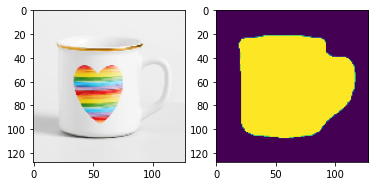

In [7]:
# Verify image and corresponding mask
raw_image = tf.keras.preprocessing.image.load_img(dataset['val'][5]["image"])
arr_image = keras.preprocessing.image.img_to_array(raw_image)
input_image = tf.image.resize(arr_image, (128, 128))

#raw_mask = tf.keras.preprocessing.image.load_img(dataset['train'][10]["segmentation_mask"])
#arr_mask = keras.preprocessing.image.img_to_array(raw_mask)
csv_arr_mask = np.loadtxt(dataset['val'][5]["segmentation_mask"], delimiter=',')
arr_mask = np.zeros((csv_arr_mask.shape[0],csv_arr_mask.shape[1],1))
arr_mask[:,:,0] = csv_arr_mask
input_mask = tf.image.resize(arr_mask, (128, 128))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
plt.subplot(1,2,2)
plt.imshow(tf.keras.preprocessing.image.array_to_img(input_mask))

In [8]:
path_trainValTest = "/content/drive/My Drive/aim/vision-project/segmentation_dataset/confidence>0.75/trainValTest/"

# Load dataset
with open(path_trainValTest + 'ecommerce-segmentation-dataset-filename.json') as json_file:
    dataset = json.load(json_file)

def load_image_from_filename(dataset):
  images = []
  masks = []
  for i in range(len(dataset)):
    if i%25==0:
      print(str(i) + "/" + str(len(dataset)))
    raw_image = tf.keras.preprocessing.image.load_img(dataset[i]["image"])
    arr_image = keras.preprocessing.image.img_to_array(raw_image)
    images.append(arr_image)
    #dataset[i]["image"] = tf.convert_to_tensor(arr_image)

    #raw_mask = tf.keras.preprocessing.image.load_img(dataset[i]["segmentation_mask"])
    #arr_mask = keras.preprocessing.image.img_to_array(raw_mask)
    csv_arr_mask = np.loadtxt(dataset[i]["segmentation_mask"], delimiter=',')
    arr_mask = np.zeros((csv_arr_mask.shape[0],csv_arr_mask.shape[1],1))
    arr_mask[:,:,0] = csv_arr_mask
    masks.append(arr_mask)
    #dataset[i]["segmentation_mask"] = tf.convert_to_tensor(arr_image)

  return images, masks


train_images, train_masks = load_image_from_filename(dataset["train"])
val_images, val_masks = load_image_from_filename(dataset["val"])
test_images, test_masks = load_image_from_filename(dataset["test"])

"""
dataset = {}
dataset["train_images"] = train_images
dataset["train_masks"] = train_masks
dataset["val_images"] = val_images
dataset["val_masks"] = val_masks
dataset["test_images"] = test_images
dataset["test_masks"] = test_masks
"""
print("")

0/285
25/285
50/285
75/285
100/285
125/285
150/285
175/285
200/285
225/285
250/285
275/285
0/95
25/95
50/95
75/95
0/95
25/95
50/95
75/95



In [9]:
def resize_image(image, size):
  return tf.image.resize(image, size)

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(img, mask):
#def load_image_train(img, segmentation_mask):
  # Image
  input_image = tf.image.resize(img, (128, 128))

  # Mask
  input_mask = tf.image.resize(mask, (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def load_image_test(img, mask):
  # Image
  input_image = tf.image.resize(img, (128, 128))

  # Mask
  input_mask = tf.image.resize(mask, (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [10]:
# Set training parameters
TRAIN_LENGTH = len(train_images) #info.splits['train'].num_examples
BATCH_SIZE = 16 #64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Preprocess (Resize, data-augmentation (only for training), normalise)
train = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train = train.map(load_image_train)
val = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val = val.map(load_image_train)
test = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test = test.map(load_image_train)

# For better performance while loading
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [11]:
tf.data.experimental.save(train, path_trainValTest+"trainMapDataset/", compression=None, shard_func=None)
tf.data.experimental.save(val, path_trainValTest+"valMapDataset/", compression=None, shard_func=None)
tf.data.experimental.save(test, path_trainValTest+"testMapDataset/", compression=None, shard_func=None)

#tr = tf.data.experimental.load(path_trainValTest+"trainMapDataset/", tf.TensorSpec(shape=(128, 128, 3), dtype=(tf.float32)))


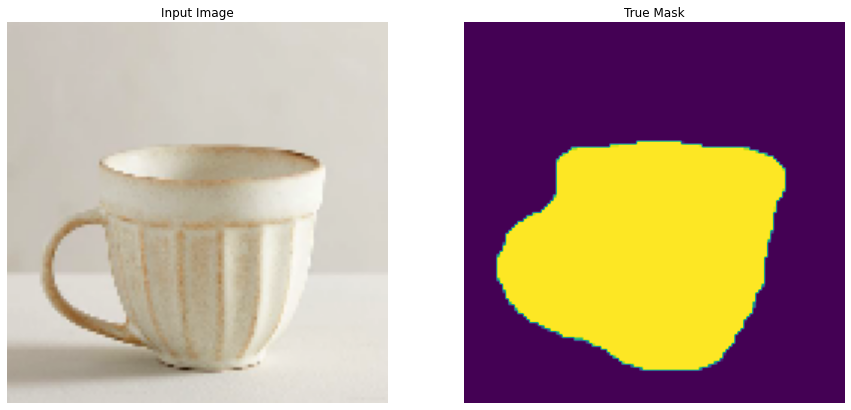

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in val.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [13]:
! pip install -q git+https://github.com/tensorflow/examples.git
! pip install -q -U tfds-nightly

     |████████████████████████████████| 3.5MB 5.7MB/s 


In [14]:
from tensorflow_examples.models.pix2pix import pix2pix

LABEL_NAMES = np.asarray([
    'background', 'couch', 'chair', 'bed', 'vase', 'bowl', 'cup',
    'wine-glass', 'potted-plant'
])

# Each pixel classified into one of OUTPUT_CHANNELS classes
OUTPUT_CHANNELS = len(LABEL_NAMES) #3

# Model
# Base model (for feature extraction)
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3],
                                               include_top=False,
                                               weights="imagenet")

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

# Decoder
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

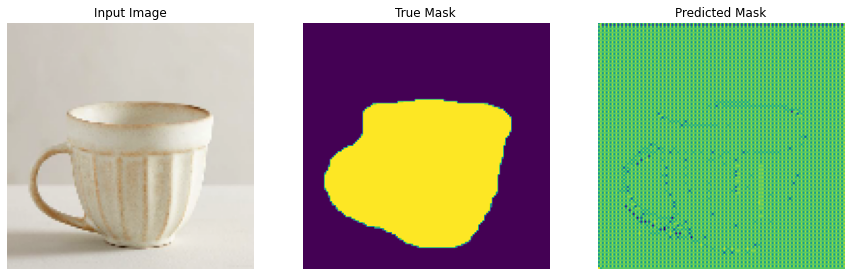

In [15]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

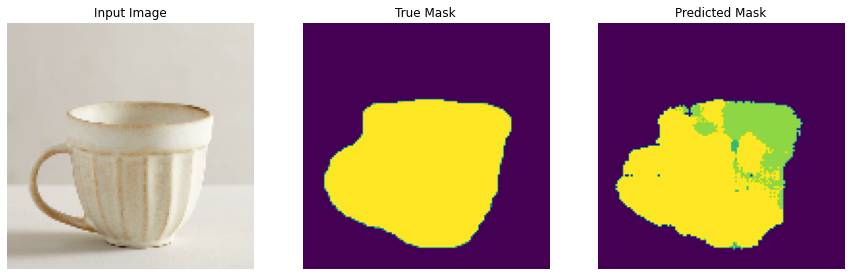


Sample Prediction after epoch 15

17/17 [==============================] - 1s 71ms/step - loss: 0.0513 - accuracy: 0.9839 - val_loss: 0.3728 - val_accuracy: 0.9069


In [21]:
## Train the model

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 15
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_STEPS = len(val_images)//BATCH_SIZE//VAL_SUBSPLITS
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback()])



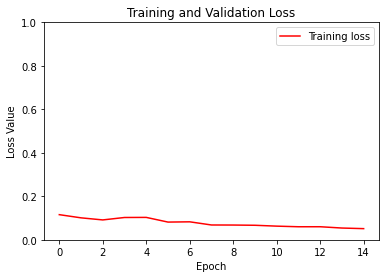

In [28]:
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
#plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

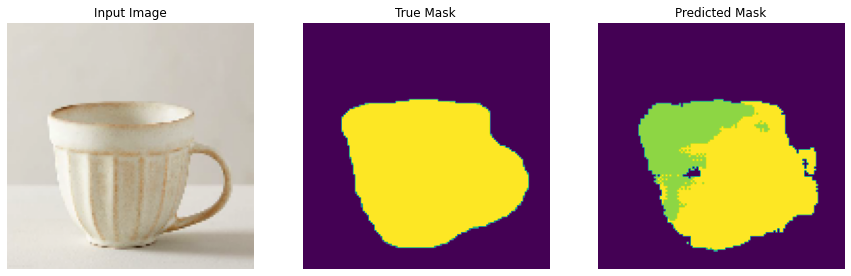

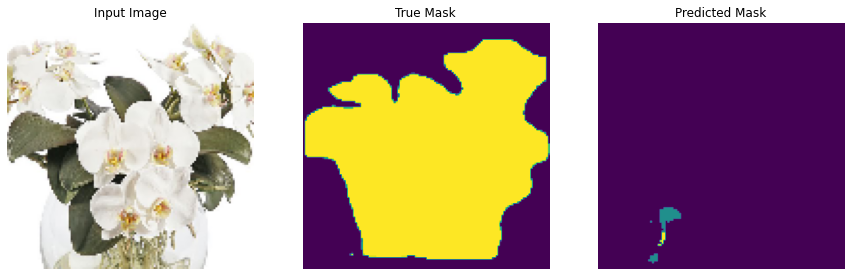

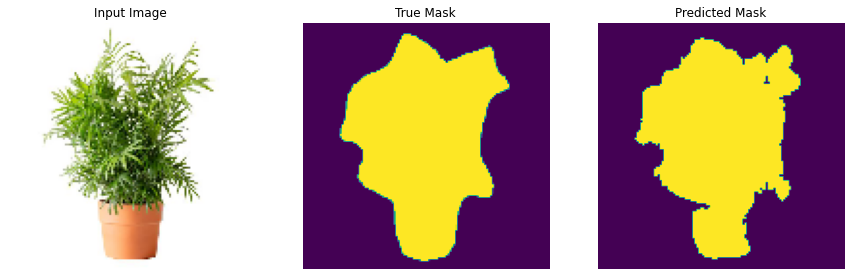

In [27]:
show_predictions(val_dataset, 3)

In [ ]:

def load_image_train_v0(img, segmentation_mask):
  # Image
  print(img)
  #raw_image = tf.keras.preprocessing.image.load_img(datapoint['image'])
  raw_image = tf.keras.preprocessing.image.load_img(img)
  arr_image = keras.preprocessing.image.img_to_array(raw_image)
  input_image = tf.image.resize(arr_image, (128, 128))
  #input_image = tf.image.resize(datapoint["image"], (128, 128))

  # Mask
  #raw_mask = tf.keras.preprocessing.image.load_img(datapoint['segmentation_mask'])
  raw_mask = tf.keras.preprocessing.image.load_img(segmentation_mask)
  arr_mask = keras.preprocessing.image.img_to_array(raw_mask)  
  input_mask = tf.image.resize(arr_mask, (128, 128))
  #input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def load_image_train_v1(img, segmentation_mask):
  # Image
  print(img)
  ##raw_image = tf.keras.preprocessing.image.load_img(datapoint['image'])
  #raw_image = tf.keras.preprocessing.image.load_img(img)
  #arr_image = keras.preprocessing.image.img_to_array(raw_image)
  #input_image = tf.image.resize(arr_image, (128, 128))
  input_image = tf.image.resize(img, (128, 128))

  # Mask
  ##raw_mask = tf.keras.preprocessing.image.load_img(datapoint['segmentation_mask'])
  #raw_mask = tf.keras.preprocessing.image.load_img(segmentation_mask)
  #arr_mask = keras.preprocessing.image.img_to_array(raw_mask)  
  #input_mask = tf.image.resize(arr_mask, (128, 128))
  input_mask = tf.image.resize(segmentation_mask, (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

ds = tf.data.Dataset.from_tensor_slices((images, masks))
ds = ds.map(load_image_train_v1)

#dataset["train"] = tf.data.Dataset.from_tensor_slices(dataset['train'])
#train = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#train = load_image_train(dataset["train"])
#val = dataset['val'].map(load_image_test)
#test = dataset['test'].map(load_image_test)
